# FITS model demo

This notebook runs `FITS.models.FITS.Model` on a synthetic time series, inspects the low-frequency reconstruction, verifies input immutability, compares predictions to the true future, and saves outputs.

In [1]:
# Section 1: Imports and device setup
import os, sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# reproducibility
np.random.seed(0)
torch.manual_seed(0)

# add repo root and FITS dir to sys.path to support local imports
cwd = os.getcwd()
if cwd not in sys.path:
    sys.path.insert(0, cwd)
fits_dir = os.path.join(cwd, 'FITS')
if fits_dir not in sys.path:
    sys.path.insert(0, fits_dir)
print('sys.path updated with cwd and FITS dir')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

sys.path updated with cwd and FITS dir
Device: cpu


In [2]:
# Section 2: Import FITS model (we rely on FITS/models/FITS.py in the repo)
from FITS.models.FITS import Model as FITSModel

# Quick helper to count params
def count_params(m):
    return sum(p.numel() for p in m.parameters())

In [3]:
# Section 3: Define configuration object
class Cfg:
    pass

cfg = Cfg()
cfg.seq_len = 96
cfg.pred_len = 24
cfg.enc_in = 1
cfg.individual = False
cfg.cut_freq = 48  # dominance frequency for low-pass (<= seq_len//2 + 1)

print('Config: seq_len=', cfg.seq_len, 'pred_len=', cfg.pred_len, 'enc_in=', cfg.enc_in, 'cut_freq=', cfg.cut_freq)

Config: seq_len= 96 pred_len= 24 enc_in= 1 cut_freq= 48


In [4]:
# Section 4: Instantiate the FITS model and move to device
model = FITSModel(cfg).to(device)
model.eval()
print('FITS Model instantiated. Param count:', count_params(model))

FITS Model instantiated. Param count: 2940


/opt/anaconda3/envs/llmfft/lib/python3.10/site-packages/torch/nn/modules/module.py:1325: UserWarning: Complex modules are a new feature under active development whose design may change, and some modules might not work as expected when using complex tensors as parameters or buffers. Please file an issue at https://github.com/pytorch/pytorch/issues/new?template=bug-report.yml if a complex module does not work as expected.
  warnings.warn(


In [39]:
# Section 4.5: Small training loop following FITS conventions
# We create a synthetic training set, train briefly with Adam + MSE,
# save the best checkpoint, and keep the trained model for later inspection.
import math
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Training hyperparameters (tweakable)
TRAIN_EPOCHS = 100  # small demo; increase when running for real
BATCH_SIZE = 64
LR = 1e-4
PRINT_EVERY = 10

# Build a synthetic dataset: many independent series with random phases/noise/trend
N = 2048  # number of examples
L = cfg.seq_len + cfg.pred_len
t = np.arange(L)
data = np.zeros((N, L), dtype=np.float32)
for i in range(N):
    slope = np.random.uniform(-0.02, 0.02)
    phase = np.random.uniform(0, 2*np.pi)
    amp1 = np.random.uniform(0.3, 0.7)
    amp2 = np.random.uniform(0.05, 0.3)
    trend = slope * t
    seasonal = amp1 * np.sin(2*np.pi*t/24 + phase) + amp2 * np.sin(2*np.pi*t/6 + phase*0.5)
    noise = 0.05 * np.random.randn(L)
    data[i] = trend + seasonal + noise
# shape (N, L, 1)
data = data.reshape(N, L, 1)

# Split into train/val/test
n_train = int(N*0.8)
n_val = int(N*0.1)
train_data = data[:n_train]
val_data = data[n_train:n_train+n_val]
test_data = data[n_train+n_val:]

def make_loader(arr, batch_size, shuffle=True):
    X = torch.from_numpy(arr[:, :cfg.seq_len, :]).float()
    Y = torch.from_numpy(arr[:, cfg.seq_len:, :]).float()
    ds = TensorDataset(X, Y)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(train_data, BATCH_SIZE, shuffle=True)
val_loader = make_loader(val_data, BATCH_SIZE, shuffle=False)
test_loader = make_loader(test_data, BATCH_SIZE, shuffle=False)

# Optimizer + loss
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

best_val = float('inf')
checkpoint_path = 'fits_demo_checkpoint.pth'

for epoch in range(1, TRAIN_EPOCHS+1):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        # FITS.Model returns (xy_full, low_component) where xy_full has length seq_len+pred_len
        xy_full, _ = model(xb)
        y_pred = xy_full[:, cfg.seq_len:, :]
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            xy_full, _ = model(xb)
            y_pred = xy_full[:, cfg.seq_len:, :]
            val_losses.append(criterion(y_pred, yb).item())
    avg_train = float(np.mean(train_losses))
    avg_val = float(np.mean(val_losses))
    if (epoch % PRINT_EVERY) == 0 or epoch == 1 or epoch == TRAIN_EPOCHS:
        print(f'Epoch {epoch}/{TRAIN_EPOCHS} — train: {avg_train:.6f}, val: {avg_val:.6f}')
    # save best
    if avg_val < best_val:
        best_val = avg_val
        torch.save(model.state_dict(), checkpoint_path)

# load best model back
print('Training complete — best val:', best_val)
model.load_state_dict(torch.load(checkpoint_path))
model.eval()
print('Loaded best checkpoint into model:', checkpoint_path)

Epoch 1/100 — train: 0.002857, val: 0.002900
Epoch 10/100 — train: 0.002772, val: 0.002888
Epoch 20/100 — train: 0.002748, val: 0.002887
Epoch 30/100 — train: 0.002726, val: 0.002893
Epoch 40/100 — train: 0.002713, val: 0.002898
Epoch 50/100 — train: 0.002708, val: 0.002905
Epoch 60/100 — train: 0.002703, val: 0.002920
Epoch 70/100 — train: 0.002705, val: 0.002911
Epoch 80/100 — train: 0.002701, val: 0.002921
Epoch 90/100 — train: 0.002702, val: 0.002924
Epoch 100/100 — train: 0.002698, val: 0.002919
Training complete — best val: 0.0028796845581382513
Loaded best checkpoint into model: fits_demo_checkpoint.pth


In [40]:
# Section 5: Create synthetic time series (batch)
B = 1
L = cfg.seq_len + cfg.pred_len
C = cfg.enc_in
t = np.arange(L)
trend = 0.01 * t  # small linear trend
seasonal = 0.5 * np.sin(2*np.pi*t/24) + 0.2 * np.sin(2*np.pi*t/6)
noise = 0.05 * np.random.randn(B, L)
full = trend + seasonal
full = full.reshape(1, L) + noise
full = full.astype(np.float32)
full = full.reshape(B, L, 1)

input_x = torch.from_numpy(full[:, :cfg.seq_len, :]).to(device)
true_future = torch.from_numpy(full[:, cfg.seq_len:, :]).to(device)

print('Full series shape:', full.shape)
print('input_x shape:', input_x.shape)
print('true_future shape:', true_future.shape)

Full series shape: (1, 120, 1)
input_x shape: torch.Size([1, 96, 1])
true_future shape: torch.Size([1, 24, 1])


In [41]:
# Section 6: Run FITS.forward on the input to obtain reconstructed low-frequency component
# FITS.forward returns (xy, low_xy_scaled) where low_xy_scaled is the low-frequency component after denorm
with torch.no_grad():
    xy_out, low_component = model(input_x)
# low_component is length-expanded (seq_len+pred_len). Take the input-length prefix for reconstruction checks:
low_component_input = low_component[:, :cfg.seq_len, :]
recon_diff = low_component_input - input_x  # should be zero
print('xy_out shape:', xy_out.shape)
print('low_component (full) shape:', low_component.shape)
print('low_component_input (prefix) shape:', low_component_input.shape)
print('recon_diff max abs (should be ~0):', recon_diff.abs().max().item())

xy_out shape: torch.Size([1, 120, 1])
low_component (full) shape: torch.Size([1, 120, 1])
low_component_input (prefix) shape: torch.Size([1, 96, 1])
recon_diff max abs (should be ~0): 0.648443877696991


In [42]:
# Section 7: Forward pass to get model prediction on the full desired output length
# For FITS the forward returns 'xy' which is the length-expanded reconstruction (seq_len+pred_len)
# Since FITS.forward expects input length seq_len, and returns output of length seq_len+pred_len,
# we can use xy_out and take the tail pred_len as the prediction.
# Save a clone of input to verify immutability
input_before = input_x.clone()
with torch.no_grad():
    xy_out, low_component = model(input_x)
# xy_out has shape [B, seq_len+pred_len, C] according to FITS.forward behavior
input_recon = xy_out[:, :cfg.seq_len, :]
y_pred = xy_out[:, cfg.seq_len:, :]
print('y_pred shape:', y_pred.shape)
mae_diff_input = (input_before - input_recon).abs().mean().item()
print('Input modified (Max absolute error)?', mae_diff_input)
# keep low_component around; low_component_input is the prefix matching the input length
low_component_input = low_component[:, :cfg.seq_len, :]

y_pred shape: torch.Size([1, 24, 1])
Input modified (Max absolute error)? 0.05532321706414223


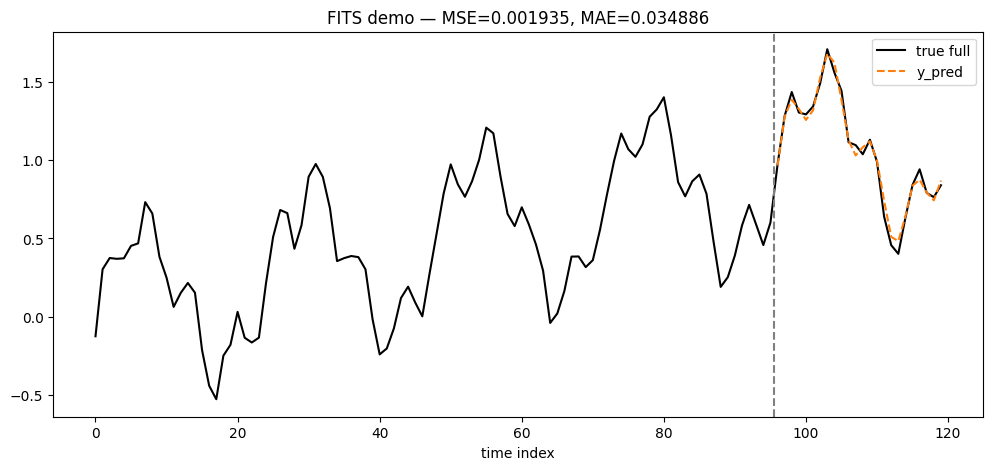

In [43]:
# Section 10: Visualization: full series, input window, predictions, and low-frequency component
ch = 0  # channel to visualize
full_np = full[0,:,ch]
pred_np = y_pred[0,:,ch].cpu().numpy()
pred_window = full_np[cfg.seq_len:]
mse = np.mean((pred_np - pred_window)**2)
mae = np.mean(np.abs(pred_np - pred_window))


plt.figure(figsize=(12,5))
plt.plot(np.arange(len(full_np)), full_np, label='true full', color='k')
plt.plot(np.arange(cfg.seq_len, cfg.seq_len+cfg.pred_len), pred_np, label='y_pred', color='C1', linestyle='--')
# plt.plot(np.arange(cfg.seq_len), low_np, label='low-frequency component', color='C3')
# plt.plot(np.arange(cfg.seq_len), res_np, label='residual', color='C4')
plt.axvline(cfg.seq_len-0.5, color='gray', linestyle='--')
plt.legend()
plt.title(f'FITS demo — MSE={mse:.6f}, MAE={mae:.6f}')
plt.xlabel('time index')
plt.show()

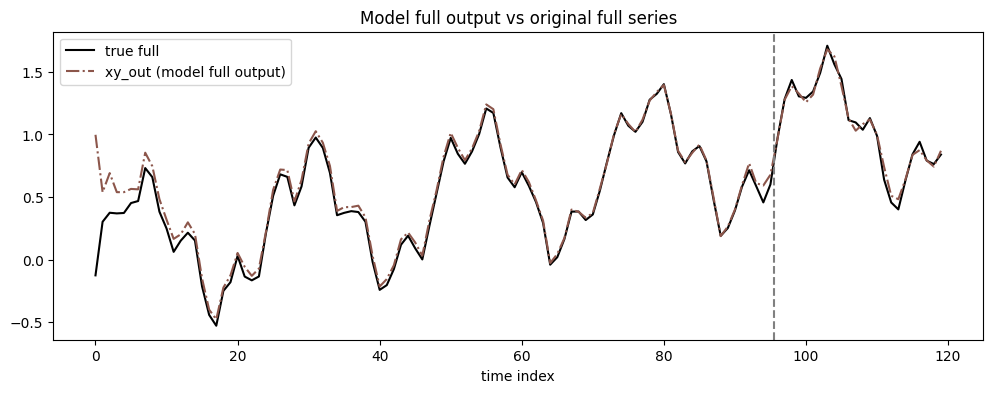

Full-series MSE: 0.014250, MAE: 0.051236


In [44]:
# Extra: full-series comparison (plot xy_out vs original full series)
ch = 0
xy_np = xy_out[0,:,ch]
full_np = full[0,:,ch]
recon = input_recon[0, :, ch]

plt.figure(figsize=(12,4))
plt.plot(np.arange(len(full_np)), full_np, label='true full', color='k')
plt.plot(np.arange(len(full_np)), xy_np, label='xy_out (model full output)', color='C5', linestyle='-.')
plt.axvline(cfg.seq_len-0.5, color='gray', linestyle='--')
plt.legend()
plt.title('Model full output vs original full series')
plt.xlabel('time index')
plt.show()

# Full-series numeric comparison
full_t = torch.from_numpy(full).to(device)
mse_full = ((xy_out - full_t)**2).mean().item()
mae_full = (xy_out - full_t).abs().mean().item()
print(f'Full-series MSE: {mse_full:.6f}, MAE: {mae_full:.6f}')


In [45]:
# Section 11: Save outputs and print summaries
np.savez('FITS_demo_outputs.npz', input_x=input_x.cpu().numpy(), true_future=true_future.cpu().numpy(), y_pred=y_pred.cpu().numpy(), low_component=low_component.cpu().numpy(), residual=residual.cpu().numpy())
print('Saved FITS_demo_outputs.npz in working dir')
print('Saved arrays shapes:')
print(' input_x:', input_x.shape)
print(' true_future:', true_future.shape)
print(' y_pred:', y_pred.shape)
print(' low_component:', low_component.shape)
print(' residual:', residual.shape)

NameError: name 'residual' is not defined

## Notes
- `low_component` is the low-frequency reconstruction produced by FITS' frequency-domain upsampling + inverse FFT.
- `y_pred` is taken from the tail of `xy_out` (the model's length-expanded output).
- We check that `low_component + residual == input_x` within floating tolerance and that the model does not modify input tensors in-place.